In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import subprocess
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [24]:
#Funcion auxiliar para correr experimentos
def correr_experimento(metodo, archivoEntrada, archivoSalida): 
    result = subprocess.run([f"../../programaRankeo", f"{metodo}", f"{archivoEntrada}", f"{archivoSalida}"], stderr = subprocess.PIPE, encoding = 'ascii')
    return int(result.stderr.split('\n')[0]) #Devuelve el tiempo de ejecucion del metodo

#Funcion auxiliar para calcular promedio rankings
def promedio_rankings(lista_contrincantes, rantings_por_equipo):
    promedio = 0
    for i in lista_contrincantes:
        promedio += rantings_por_equipo['Ranking'][i]
    return promedio/len(lista_contrincantes)

In [4]:
#Guardamos los experimentos de manera que queden de la forma: [metodo, archivo de salida(donde estaran los rankings)]
experimentos = []
for i in range(3):
    experimentos.append([i, f'../resultados/nba_2016_ranking_{i}.out'])

In [5]:
columnas = ["Metodo","Tiempo promedio (ns)"]
filas = []
numero = 1
T = 50 # Numero de veces que se ejecuta cada experimento (para promediar tiempo de ejecucion) 

for experimento in experimentos:
    # Voy mostrando que experimento se esta ejecutando.
    clear_output(wait=True)
    display("Experimento: " + str(numero) + "/" + str(len(experimentos)))
    numero += 1

    # Ejecutamos el experimento T veces y obtenemos la mediana.
    tiempos = []
    for i in range(T):
        tiempos.append(correr_experimento(experimento[0], '../data/nba_2016_scores.dat', experimento[1]))
    tiempo = np.median(tiempos)
    
    filas.append([experimento[0], tiempo])

df_resultado = pd.DataFrame(filas, columns=columnas)
df_resultado.to_csv("../resultados/tiempos_ejecucion_nba_2016.csv", index=False, header=True)

'Experimento: 3/3'

# Rankings

In [6]:
#Abrimos el csv que contiene los nombres de equipo
nombres_equipos = pd.read_csv('../data/nba_2016_teams.csv')

#Abrimos el archivo que tiene los rankings conseguidos por cada metodo
ranking_por_equipo_CMM = pd.read_csv('../resultados/nba_2016_ranking_0.out',sep='\n',header=None)
ranking_por_equipo_WP = pd.read_csv('../resultados/nba_2016_ranking_1.out',sep='\n',header=None)
ranking_por_equipo_TM = pd.read_csv('../resultados/nba_2016_ranking_2.out',sep='\n',header=None)

#Guardo datos que usare para comparar CMM con WP
ranking_por_equipo_CMM_raw = ranking_por_equipo_CMM

#Renombramos los index para que cada equipo quede asociado a su ranking
ranking_por_equipo_CMM.rename(columns={0:'Ranking'},index=lambda x: nombres_equipos.iloc[x,1],inplace=True)
ranking_por_equipo_WP.rename(columns={0:'Ranking'},index=lambda x: nombres_equipos.iloc[x,1],inplace=True)
ranking_por_equipo_TM.rename(columns={0:'Ranking'},index=lambda x: nombres_equipos.iloc[x,1],inplace=True)

#Ordenamos los equipos segun ranking
ranking_por_equipo_CMM_sorted = ranking_por_equipo_CMM.sort_values(by=['Ranking'], ascending=False,inplace=False)
ranking_por_equipo_WP_sorted = ranking_por_equipo_WP.sort_values(by=['Ranking'], ascending=False,inplace=False)
ranking_por_equipo_TM.sort_values(by=['Ranking'], ascending=False,inplace=True)

In [7]:
#Vemos el top 3 del ranking segun CMM
ranking_por_equipo_CMM_sorted.head(6)

Ranking
Golden State   0.874063
San Antonio    0.803976
Cleveland      0.692428
Toronto        0.659347
Oklahoma City  0.655552
LA Clippers    0.629708

In [8]:
#Vemos el top 3 del ranking segun WP
ranking_por_equipo_WP_sorted.head(6)

Ranking
Golden State   0.909091
San Antonio    0.850746
Cleveland      0.712121
Toronto        0.681818
Oklahoma City  0.671642
LA Clippers    0.636364

In [9]:
#Vemos el top 3 del ranking segun TM(Team Method)
ranking_por_equipo_TM.head(6)

Ranking
Golden State   1.000000
Oklahoma City  0.756228
Houston        0.538256
Boston         0.529359
Portland       0.506228
Sacramento     0.477758

In [10]:
#Preparamos los DataFrame para plotear un grafico de barras
ranking_por_equipo_CMM.reset_index(inplace=True)
ranking_por_equipo_CMM_sorted.reset_index(inplace=True)
ranking_por_equipo_CMM.rename(columns={'index': 'Equipo'},inplace=True)
ranking_por_equipo_CMM_sorted.rename(columns={'index': 'Equipo'},inplace=True)

ranking_por_equipo_WP.reset_index(inplace=True)
ranking_por_equipo_WP_sorted.reset_index(inplace=True)
ranking_por_equipo_WP.rename(columns={'index': 'Equipo'},inplace=True)
ranking_por_equipo_WP_sorted.rename(columns={'index': 'Equipo'},inplace=True)

ranking_por_equipo_TM.reset_index(inplace=True)
ranking_por_equipo_TM.rename(columns={'index': 'Equipo'},inplace=True)

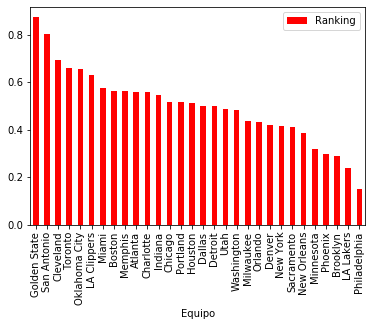

In [11]:
#Ploteamos el grafico de barras para CMM
ranking_por_equipo_CMM_sorted.plot(x='Equipo',y='Ranking',kind='bar',color='red')

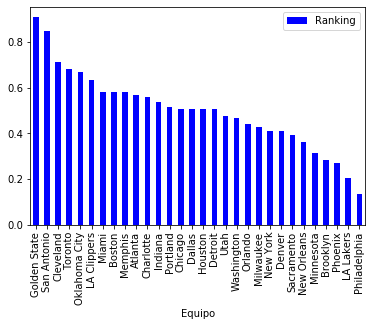

In [12]:
#Ploteamos el grafico de barras para WP
ranking_por_equipo_WP_sorted.plot(x='Equipo',y='Ranking',kind='bar',color='blue')

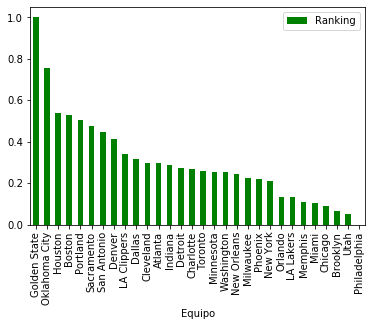

In [13]:
#Ploteamos el grafico de barras para TM
ranking_por_equipo_TM.plot(x='Equipo',y='Ranking',kind='bar',color='green')

In [14]:
#Ahora comparemos los ratings conseguido por CMM con el conseguido por WP
comparacion_ratings = pd.DataFrame()
comparacion_ratings['Equipo'] = ranking_por_equipo_CMM['Equipo']
comparacion_ratings['Diferencia absoluta'] = ranking_por_equipo_CMM['Ranking'] - ranking_por_equipo_WP['Ranking']
comparacion_ratings['Diferencia absoluta'] = comparacion_ratings['Diferencia absoluta'].apply(lambda x: abs(x))
comparacion_ratings.sort_values(by=['Diferencia absoluta'], ascending=False,inplace=True)
comparacion_ratings.head(3)

Equipo  Diferencia absoluta
26   San Antonio             0.046771
9   Golden State             0.035028
13     LA Lakers             0.030839

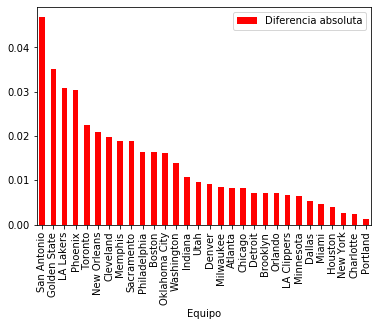

In [15]:
#Graficamos un histograma con las diferencias en los rantings
comparacion_ratings.sort_values(by=['Diferencia absoluta'], ascending=False,inplace=True)
comparacion_ratings.plot(x='Equipo',y='Diferencia absoluta',kind='bar',color='red')

In [16]:
#Vamos a ver el promedio de las diferencias en los ratings conseguidos por cada metodo
promedio_diferencias = 0
for i in comparacion_ratings['Diferencia absoluta']:
    promedio_diferencias += i
promedio_diferencias /= len(comparacion_ratings.index)
promedio_diferencias

0.01387154087234366

In [17]:
#Veamos ahora las diferencias entre los rankings (son todos swaps)
posiciones_distintas = pd.DataFrame(columns=['Posición','CMM','WP'])
comparacion_rankings = pd.DataFrame()
comparacion_rankings['Ranking CMM'] = ranking_por_equipo_CMM_sorted['Equipo']
comparacion_rankings['Ranking WP'] = ranking_por_equipo_WP_sorted['Equipo']
for i in range(len(comparacion_rankings.index)):
    if(comparacion_rankings['Ranking CMM'][i] != comparacion_rankings['Ranking WP'][i]):
        posiciones_distintas.loc[len(posiciones_distintas)] = [i,comparacion_rankings['Ranking CMM'][i],comparacion_rankings['Ranking WP'][i]]

posiciones_distintas

Posición        CMM         WP
0       12    Chicago   Portland
1       13   Portland    Chicago
2       14    Houston     Dallas
3       15     Dallas    Houston
4       19  Milwaukee    Orlando
5       20    Orlando  Milwaukee
6       21     Denver   New York
7       22   New York     Denver
8       26    Phoenix   Brooklyn
9       27   Brooklyn    Phoenix

In [18]:
#Vemos cuales son las posiciones disputadas donde hay un "swap"
posiciones_disputadas = pd.DataFrame(columns=['Posición disputada', 'CMM', 'WP'])

for i in range(0,len(posiciones_distintas.index),2):
    posiciones_disputadas.loc[len(posiciones_disputadas)]=[posiciones_distintas['Posición'][i], posiciones_distintas['CMM'][i], posiciones_distintas['WP'][i]]

posiciones_disputadas

Posición disputada        CMM        WP
0                 12    Chicago  Portland
1                 14    Houston    Dallas
2                 19  Milwaukee   Orlando
3                 21     Denver  New York
4                 26    Phoenix  Brooklyn

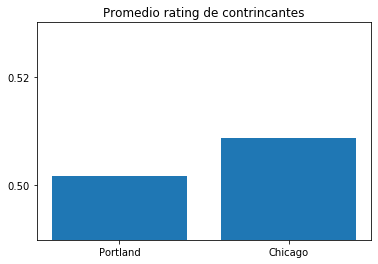

In [47]:
#Calculo el promedio de los rankings de los contrincantes
datos_partidos = pd.read_csv('../data/nba_2016_scores_caracteristicas.csv',header=None)
#Cambio nombres de las columnas para que sean lo que representan
datos_partidos.rename(columns={0:'Equipo 1',1:'Puntos equipo 1',2:'Equipo 2',3:'Puntos equipo 2'}, inplace=True)

contrincantes_por_equipo = []
for i in range(30):
    contrincantes_por_equipo.append([])

for i in datos_partidos.index:
    contrincantes_por_equipo[datos_partidos['Equipo 1'][i]-1].append(datos_partidos['Equipo 2'][i]-1)
    contrincantes_por_equipo[datos_partidos['Equipo 2'][i]-1].append(datos_partidos['Equipo 1'][i]-1)

#Me guardo una lista de los contrincantes de cada equipo
contrincantes_denver = contrincantes_por_equipo[7]
contrincantes_new_york = contrincantes_por_equipo[19]
contrincantes_portland = contrincantes_por_equipo[24]
contrincantes_chicago = contrincantes_por_equipo[4]

promedio_denver = promedio_rankings(contrincantes_denver, ranking_por_equipo_CMM_raw)
promedio_new_york = promedio_rankings(contrincantes_new_york, ranking_por_equipo_CMM_raw)
promedio_portland = promedio_rankings(contrincantes_portland, ranking_por_equipo_CMM_raw)
promedio_chicago = promedio_rankings(contrincantes_chicago, ranking_por_equipo_CMM_raw)

#Preparo para graficar
equipos_conflicto_1 = ['Portland','Chicago']
equipos_conflicto_2 = ['New York','Denver']
promedios_conflicto_1 = [promedio_portland,promedio_chicago]
promedios_conflicto_2 = [promedio_new_york,promedio_denver]

fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('')
#Colocamos una etiqueta en el eje X
ax.set_title('Promedio rating de contrincantes')
plt.ylim(0.49, 0.53)
plt.yticks(np.arange(0.5, 0.52, step=0.02))
#Creamos la grafica de barras utilizando 'paises' como eje X y 'ventas' como eje y.
plt.bar(equipos_conflicto_1, promedios_conflicto_1)
#Finalmente mostramos la grafica con el metodo show()
plt.show()

In [46]:
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('')
#Colocamos una etiqueta en el eje X
ax.set_title('Promedio rating de contrincantes')
plt.ylim(0.49, 0.53)
plt.yticks(np.arange(0.5, 0.52, step=0.02))
#Creamos la grafica de barras utilizando 'paises' como eje X y 'ventas' como eje y.
plt.bar(equipos_conflicto_2, promedios_conflicto_2,color='red')
#Finalmente mostramos la grafica con el metodo show()
plt.show()

# Tiempo de ejecución

In [41]:
#Abrimos el archivo que contiene el tiempo de ejecucion promedio de cada metodo
promedio_tiempos = pd.read_csv('../resultados/tiempos_ejecucion_nba_2016.csv')
#Renombramos
promedio_tiempos.replace({0: "CMM", 1: "WP", 2: "TM"}, inplace=True)
#Pasamos la metrica a milisegundos
promedio_tiempos.rename(columns={'Tiempo promedio (ns)': 'Tiempo promedio (ms)'}, inplace=True)
for i in range(3):
    promedio_tiempos.iloc[i,1] /= 1E+6

promedio_tiempos

Metodo  Tiempo promedio (ms)
0    CMM              0.255488
1     WP              0.002946
2     TM              0.010671

In [42]:
#Ploteamos lo anterior
promedio_tiempos.plot(x='Metodo',y='Tiempo promedio (ms)',kind='bar')

In [43]:
#Comparemos WP y TM por separado, ya que el tiempo de ejecucion de estas es mas parecido
promedio_tiempos.drop(index=0).plot(x='Metodo',y='Tiempo promedio (ms)',kind='bar')